In [2]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


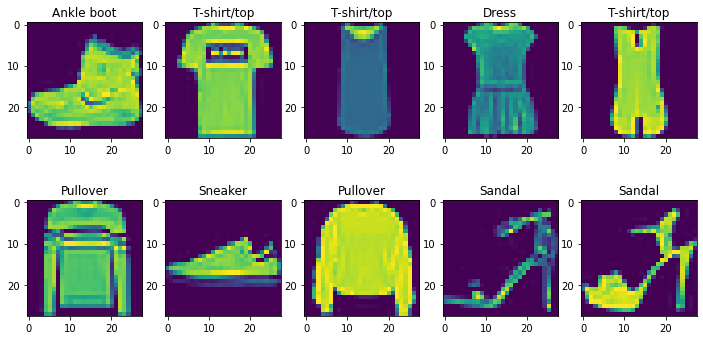

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5
    ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
    ax[idx, idy].set_title(class_names[train_labels[i]])

In [5]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [6]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.5371 - accuracy: 0.8018 - val_loss: 0.3594 - val_accuracy: 0.8702
Epoch 2/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3488 - accuracy: 0.8731 - val_loss: 0.3034 - val_accuracy: 0.8878
Epoch 3/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3010 - accuracy: 0.8890 - val_loss: 0.2899 - val_accuracy: 0.8915
Epoch 4/100
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2729 - accuracy: 0.8995 - val_loss: 0.2836 - val_accuracy: 0.8918
Epoch 5/100
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2513 - accuracy: 0.9067 - val_loss: 0.2767 - val_accuracy: 0.9013
Epoch 6/100
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2343 - accuracy: 0.9131 - val_loss: 0.2837 - val_accuracy: 0.8988
Epoch 7/100
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2188 - accuracy: 0.9180 - val_loss: 0.2713 -

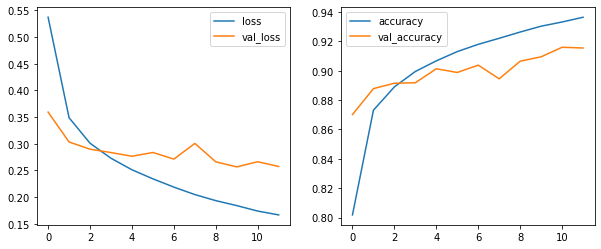

In [7]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [8]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[5.2048315e-15, 9.9952212e-14, 8.9000403e-15, 4.8764530e-13,
        6.1360197e-15, 2.0656291e-08, 4.6311476e-14, 4.7895290e-05,
        1.1052475e-14, 9.9995208e-01],
       [6.9429391e-09, 7.5372153e-11, 9.9842286e-01, 2.5329916e-10,
        5.7635980e-04, 2.7028664e-12, 1.0007330e-03, 1.7879880e-13,
        4.6369366e-09, 1.4284640e-13],
       [8.1431258e-18, 1.0000000e+00, 1.8006221e-20, 8.4059397e-19,
        4.7093928e-18, 1.0935906e-22, 9.3736359e-20, 1.1894503e-25,
        5.4120246e-19, 3.3682467e-25],
       [3.6037392e-13, 1.0000000e+00, 8.4748586e-15, 2.8333390e-12,
        3.2651033e-13, 6.8226531e-18, 5.1933230e-14, 2.0753604e-19,
        6.7243222e-15, 1.9330986e-19],
       [1.3136120e-01, 8.0769233e-08, 5.5571510e-03, 3.4594526e-05,
        5.7165493e-04, 2.3943656e-08, 8.6247420e-01, 4.4068593e-09,
        1.0580029e-06, 4.2592427e-09]], dtype=float32)

In [9]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6], dtype=int64)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.81      0.88      0.84      1000
       Dress       0.93      0.89      0.91      1000
        Coat       0.86      0.83      0.85      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.74      0.74      0.74      1000
     Sneaker       0.92      0.99      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,854,0,20,10,2,1,105,0,8,0
Trouser,3,982,0,10,1,0,2,0,2,0
Pullover,18,1,878,10,27,0,65,0,1,0
Dress,18,13,15,887,30,0,37,0,0,0
Coat,2,0,100,16,830,0,52,0,0,0
Sandal,0,0,0,0,0,966,0,29,0,5
Shirt,101,0,69,22,68,0,737,0,3,0
Sneaker,0,0,0,0,0,5,0,986,0,9
Bag,3,2,4,3,2,1,3,4,978,0
Ankle boot,0,0,0,0,0,4,0,51,1,944
